In [1]:
import numpy as np
import torch
from grid2vec import *
import json
import pandas as pd
from utils import Timer, copy_file
from joblib import Parallel, delayed
from traj2grid import Traj2Grid
import traj_dist.distance as tdist
from logging import raiseExceptions
from parameters import *
import numpy as np
import time

timer = Timer()

In [2]:
import modin.pandas as pd
import ray
ray.init()


E0322 10:25:00.537783006   37412 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0322 10:25:00.613058343   37412 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0322 10:25:00.669207796   37412 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


{'node_ip_address': '202.117.43.251',
 'raylet_ip_address': '202.117.43.251',
 'redis_address': '202.117.43.251:50103',
 'object_store_address': '/tmp/ray/session_2022-03-22_10-24-59_299549_37412/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2022-03-22_10-24-59_299549_37412/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2022-03-22_10-24-59_299549_37412',
 'metrics_export_port': 59722,
 'gcs_address': '202.117.43.251:37809',
 'node_id': '155b073b9750b32dbc1f7621a168bd1c4a52464880bfcb9bdc9a43f5'}

In [ ]:
row_num = 400
column_num = 400

timer = utils.Timer()
t2g = Traj2Grid(row_num, column_num, min_lon, min_lat, max_lon, max_lat)
print(t2g.gird_shape)
timer.tik()
value_counts = None
for i in range(1, 31):
    df = pd.read_csv(
        f"{data_dir}/full/gps_201611{str(i).zfill(2)}",
        names=["name", "order_id", "time", "lon", "lat"],
        usecols=["lon", "lat"],
    )  # lon经度 lat纬度
    timer.tok(f"read{str(i).zfill(2)}")
    df = df.apply(t2g.point2grid, axis=1).squeeze()
    timer.tok(f"apply{str(i).zfill(2)}")
    if value_counts is not None:
        value_counts = value_counts.add(df.value_counts(), fill_value=0)
    else:
        value_counts = df.value_counts()
    timer.tok(f"value_counts{str(i).zfill(2)}")
value_counts = value_counts.to_dict()


In [27]:
grid2idx = t2g.build_vocab(value_counts, lower_bound=10)
print(f"剩{len(grid2idx)}/{len(value_counts)}，筛掉{round(100 - 100 * len(grid2idx) / len(value_counts))}%")


剩44612/48068，筛掉7%


In [ ]:
str_grid2idx = {f"({grid[0]},{grid[1]})": grid2idx[grid] for grid in grid2idx}
json.dump(str_grid2idx, open(f"data/str_grid2idx_{row_num}_{len(str_grid2idx)}.json", "w"))

In [32]:
ray.shutdown()
import pandas as pd

In [2]:
file_path = "data/1m_gps_20161101"
dict_path = "data/str_grid2idx_400_44612.json"

# read data
timer.tik()
df = pd.DataFrame(pd.read_csv(file_path, header=None))
df.columns = ["name", "id", "time", "lon", "lat"]  # lon经度 lat纬度
timer.tok("read {}".format(file_path))

# load dict & set converter
str_grid2idx = json.load(open(dict_path))
t2g = Traj2Grid(row_num, column_num, min_lon, min_lat, max_lon, max_lat)
grid2idx = {eval(g): str_grid2idx[g] for g in list(str_grid2idx)}
t2g.set_vocab(grid2idx)
timer.tok(f"load dict{dict_path}")


def group_concat(group: pd.DataFrame):
    origin_traj = [((row["lon"]), row["lat"])
                   for index, row in group.iterrows()]
    traj_1d = t2g.convert1d(origin_traj)
    series = pd.Series({
        "origin_trajs": origin_traj,
        "trajs": traj_1d,
        "origin_len": len(origin_traj),
        "len": len(traj_1d),
        "max_lon": group["lon"].max(),
        "max_lat": group["lat"].max(),
        "min_lon": group["lon"].min(),
        "min_lat": group["lat"].min(),
    })
    return series


# group-apply
res = Parallel(n_jobs=8)(delayed(group_concat)(group)for name, group in df.groupby("id"))
df = pd.DataFrame(res)
timer.tok("group-apply")


tik start
read data/1m_gps_20161101 done, 1.713s after tik start
load dictdata/str_grid2idx_400_44612.json done, 2.134s after tik start
group-apply done, 294.467s after tik start


count    5650.000000
mean      106.143009
std        73.535868
min         1.000000
25%        49.000000
50%        94.000000
75%       148.000000
max       604.000000
Name: len, dtype: float64

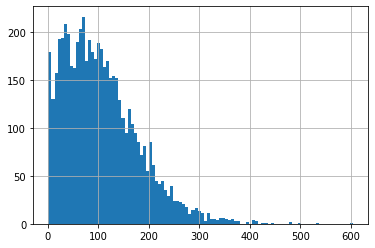

In [3]:
df['len'].hist(bins=100)
df['len'].describe()

In [6]:

# filter
dff = df[:]
pad = 0.0002
dff = dff[(dff["min_lon"] > 104.04214 + pad) & (dff["max_lon"] < 104.12958 - pad)]
dff = dff[(dff["min_lat"] > 30.65294 + pad) & (dff["max_lat"] < 30.72775 - pad)]
dff = dff[(dff["len"] > 10) & (dff["len"] < 256)]

print(f"剩{len(dff)}/{len(df)}条，筛掉{round(100 - 100 * len(dff) / len(df))}%")


剩4765/5650条，筛掉16%


In [ ]:
metric = "edr"
eps = 0.00029

# calculate distance
origin_trajs = dff["origin_trajs"].to_list()
arr = [np.array(origin_traj) for origin_traj in origin_trajs]
length = len(arr)
dis_matrix = np.zeros((length, length))
if metric == "edr":
    def cal_dis(i, j, x, y, n):
        dis = tdist.edr(x, y, eps=eps)
        if i == j + 1:
            timer.tok(f'{i}-{round((i * i) / (n * n) * 100, 2)}%')
        return i, j, dis

    res = Parallel(n_jobs=44)(
        delayed(cal_dis)(i, j, arr[i], arr[j], length - 1) for i in range(length) for j in range(i))
    timer.tok("calculate distance")
    for (i, j, dis) in res:
        dis_matrix[i, j] = dis
        dis_matrix[j, i] = dis
else:
    raiseExceptions("metric {} is not supported".format(metric))

In [ ]:
full = False

sorted_index = np.argsort(dis_matrix, axis=1)
dict_save = {'trajs': dff["trajs"].to_list(
       ), "sorted_index": sorted_index.tolist(), 'origin_trajs': origin_trajs}
if full:
    dict_save["dis_matrix"] = dis_matrix.tolist()
    json.dump(dict_save, open(file_path + "_dataset_full.json", "w"))
else:
    json.dump(dict_save, open(file_path + "_dataset.json", "w"))
timer.tok("save")


In [10]:
str_grid2idx = json.load(open("data/str_grid2idx_300.json"))
grid2idx = {eval(c): str_grid2idx[c] for c in list(str_grid2idx)}
print(len(grid2idx))

33189


In [ ]:
max_lon = 0
max_lat = 0
min_lon = 999
min_lat = 999
timer.tik()
for i in range(1, 31):
    df = pd.read_csv("data/full/gps_201611"+str(i).zfill(2),
                     names=["name", "order_id", "time", "lon", "lat"],
                     usecols=["lon", "lat"])
    max_lon = df['lon'].max() if df['lon'].max() > max_lon else max_lon
    min_lon = df['lon'].min() if df['lon'].min() < min_lon else min_lon
    max_lat = df['lat'].max() if df['lat'].max() > max_lat else max_lat
    min_lat = df['lat'].min() if df['lat'].min() < min_lat else min_lat
    timer.tok(str(i).zfill(2))
    print(max_lon, min_lon, max_lat, min_lat)

In [9]:
with open('data/str_grid2idx_800.json') as f:
    str_grid2idx = json.load(f)
    f.close()
grid2idx = {eval(c): str_grid2idx[c] for c in list(str_grid2idx)}

dataset = GridEmbeddingDataset(grid2idx, window_size=20, neg_rate=100)
model = Grid2Vec(len(dataset), 256)
cp = torch.load('model/checkpoint_256_299_0_0.694.pth')
model.load_state_dict(cp['model'])
weight2 = np.load("model/grid_embedding_256_0.8.npy")
weight3 = np.load("model/grid_embedding_384_0.73.npy")
print(evaluate_grid2vec(model.input_embedding(), dataset, test_num=500))
print(evaluate_grid2vec(weight2, dataset, test_num=500))
print(evaluate_grid2vec(weight3, dataset, test_num=500))


0.7862
0.7921
0.7029
